## Movie_Review_Sentiment_Classification
### (영화리뷰 감성분석)

***
#### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import tensorflow as tf
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter

In [2]:
data = pd.read_csv("ratings.txt", delimiter = '\t')
data = data.drop(columns = 'id')

In [3]:
df1 = pd.read_csv("0112.csv", encoding="utf-8")
df2 = pd.read_csv("0113.csv", encoding="utf-8")
df3 = pd.read_csv("0114.csv", encoding="utf-8")
df4 = pd.read_csv("0115.csv", encoding="utf-8")
df5 = pd.read_csv("0116.csv", encoding="utf-8")
df6 = pd.read_csv("0117.csv", encoding="utf-8")
df7 = pd.read_csv("0118.csv", encoding="utf-8")
df8 = pd.read_csv("0119.csv", encoding="utf-8")
df9 = pd.read_csv("0120.csv", encoding="utf-8")
df10 = pd.read_csv("0121.csv", encoding="utf-8")
df11 = pd.read_csv("0122.csv", encoding="utf-8")
df12 = pd.read_csv("0123.csv", encoding="utf-8")
df13 = pd.read_csv("0124.csv", encoding="utf-8")
df14 = pd.read_csv("0125.csv", encoding="utf-8")
df15 = pd.read_csv("0126.csv", encoding="utf-8")
df16 = pd.read_csv("0127.csv", encoding="utf-8")
df17 = pd.read_csv("0128.csv", encoding="utf-8")
df18 = pd.read_csv("0129.csv", encoding="utf-8")
df19 = pd.read_csv("0130.csv", encoding="utf-8")
df20 = pd.read_csv("0131.csv", encoding="utf-8")
df21 = pd.read_csv("0201.csv", encoding="utf-8")
df22 = pd.read_csv("0202.csv", encoding="utf-8")
df23 = pd.read_csv("0203.csv", encoding="utf-8")
df24 = pd.read_csv("0204.csv", encoding="utf-8")
df25 = pd.read_csv("0205.csv", encoding="utf-8")
df26 = pd.read_csv("0206.csv", encoding="utf-8")
df27 = pd.read_csv("0207.csv", encoding="utf-8")
df28 = pd.read_csv("0208.csv", encoding="utf-8")

In [4]:
data2 = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,
                   df19,df20,df21,df22,df23,df24,df25,df26,df27,df28], axis=0, ignore_index = True)
data2 = data2.rename(columns = {'sentence':'document'})

def rating_to_label(score):
    if score >= 8:
        return '1'
    if score <= 5:
        return '0'
    
data2['label'] = data2['score'].apply(lambda x: rating_to_label(x))
data2 = data2.drop(columns = 'score')
data2 = data2.dropna(axis = 0)

In [5]:
data2.set_index('document',inplace=True)
data2 = data2.astype('int')
data2.reset_index(inplace=True)

In [6]:
df = pd.concat([data2, data], axis=0, ignore_index = True)

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

***  
#### 2. 데이터로더 구성
> **1) 데이터의 중복 제거  
2) NaN 결측치 제거  
3) 한국어 토크나이저로 토큰화  
4) 불용어(Stopwords) 제거  
5) 사전word_to_index 구성  
6) 텍스트 스트링을 사전 인덱스 스트링으로 변환  
7) X_train, y_train, X_test, y_test, word_to_index 리턴**  

In [8]:
from eunjeon import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    # 1-1) 학습데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
#     1-2) 학습데이터에서 NaN 결측치 제거
    train_data =train_data.dropna(how='any')
    
#     2-1) 테스트데이터의 중복 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
#     2-2) 테스트데이터의 NaN 결측치 제거
    test_data =train_data.dropna(how='any')
    
#     3-1) 학습데이터 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        # sentence에 있는 문장을 뜻을 가질수 있는 최소단위 '형태소'로 
        # 분리해서 토큰으로 가지고 있어줘
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어(stopwords) 제거
        # temp_X의 토큰을 X_train에 넣어줘.
        X_train.append(temp_X)

#     3-2) 테스트데이터 한국어 토크나이저로 토큰화
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어(stopwords) 제거
        X_test.append(temp_X)

#     5) 사전word_to_index 구성
    # np.concatenate(배열) : 해당 배열을 오른쪽에 추가하기
    # .tolost() : 앞의 배열을 np.unit이 아닌 list로 바꿔줌
    # => words는 X_train의 배열을 가진 list가 됨.
    words = np.concatenate(X_train).tolist()
    # Counter(words)
    # words에서 단어들의 갯수를 세어 {단어1:갯수, 단어2:갯수, ...} 형태의
    # 딕셔너리를 형성함.
    # ex) words = [가, 나, 가, 다, 나, 가, 라] 일때
    # Counter(words)를 하면
    # 결과물로 ({가:3, 나:2, 다:1, 라:1})의 형태임.
    counter = Counter(words)
    # counter.most_common(10000-4)
    # conter에서 가장 많이 사용된 단어를 [(단어1, 횟수),(단어2, 횟수), ...]의 형태로
    # 정렬하여 가장 많이 나온 횟수부터 가장 적게나온 횟수 순으로 (10000-4)개를 정렬해준다.
    counter = counter.most_common(10000-4)
    # vocab은 counter에 ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']를 
    # 각각 key로서 넣는데 할당되지 않는 부분에서 넣는다.
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 인덱스 : 단어로 되어있는 부분을 단어 : 인덱스번호 형식으로 바꿔준다.
    word_to_index = {word:index for index, word in enumerate(vocab)}

#     6) 텍스트 스트링을 사전 인덱스 스트링으로 변환  
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    # map() 함수는 for문과 같은 반복문을 사용하지 않아도 
    # 지정한 함수로 인자를 여러번 전달해 그 결과를 list 형태로 
    # 뽑아 주는 유용한 함수이다.
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

#     7) X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
   
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
# 데이터의 갯수 확인
print('학습용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

학습용 리뷰 개수 : 203708
테스트용 리뷰 개수 : 51393


In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}
# 인덱스 : 단어 형태로 바꾸어준다.

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주었을 경우, 
# 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로
# encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 
# decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 
# 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### **3. 모델구성을 위한 데이터 분석 및 가공**
> **1) 데이터셋 내 문장 길이 분포  
> 2) 적절한 최대 문장 길이 지정  
> 3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가**


**1) 데이터셋 내 문장 길이 분포**

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이, 최대길이, 표준편차 확인
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  17.5496669235716
문장길이 최대 :  463
문장길이 표준편차 :  17.523029639346525


**2) 적절한 최대 문장 길이 지정**

In [13]:
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
# 전체문장의 약 95%가 포함되도록 설정

pad_sequences maxlen :  52
전체 문장의 0.9551512711885207%가 maxlen 설정값 이내에 포함됩니다. 


**3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가**

In [14]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, padding='pre', 
                                                        maxlen=maxlen)
# PAD를 앞쪽에 배치하여야 소실되어도 학습이 잘 됨.

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(203707, 52)


***
#### 4. 모델구성 및 validation set 구성
> **1) 1-D Convolution Neural Network(1-D CNN)  
> 2) GlobalMaxPooling1D()  
> 3) RNN  
> 4) 1-D CNN + RNN   
> 5) Validation set구성**


In [15]:
# 파라미터를 고정시킴
vocab_size = len(index_to_word)  # 어휘 사전의 크기
word_vector_dim = 300    # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.

***
**1) 1-D Convolution Neural Network(1-D CNN)** 

In [16]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          33616     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 1

**2) GlobalMaxPooling1D()**

In [17]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 2408      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


**3) RNN**

In [18]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경가능)
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         3000000   
                                                                 
 lstm (LSTM)                 (None, 16)                20288     
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,020,433
Trainable params: 3,020,433
Non-trainable params: 0
_________________________________________________________________


**4) 1-D CNN + RNN**

In [19]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.MaxPooling1D(5))
model4.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경가능)
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          33616     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                      

**5) Validation set구성**

In [20]:
# validation set 40000건 분리(전체 data의 약 20%)
X_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지
partial_X_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(163707, 52)
(163707,)


#### 5. 모델 훈련
***
**1) 1-D Convolution Neural Network(1-D CNN)** 

In [21]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es],
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model1.evaluate(X_test,  y_test, verbose=2)

print("1-D CNN모델",results)

Epoch 1/20
320/320 [==============================] - 42s 131ms/step - loss: 0.4267 - accuracy: 0.7862 - val_loss: 0.3383 - val_accuracy: 0.8522
Epoch 2/20
320/320 [==============================] - 41s 127ms/step - loss: 0.2945 - accuracy: 0.8746 - val_loss: 0.3295 - val_accuracy: 0.8559
Epoch 3/20
320/320 [==============================] - 41s 129ms/step - loss: 0.2353 - accuracy: 0.9039 - val_loss: 0.3376 - val_accuracy: 0.8572
Epoch 4/20
320/320 [==============================] - 42s 131ms/step - loss: 0.1676 - accuracy: 0.9363 - val_loss: 0.3826 - val_accuracy: 0.8511
Epoch 5/20
320/320 [==============================] - 43s 136ms/step - loss: 0.1126 - accuracy: 0.9602 - val_loss: 0.4630 - val_accuracy: 0.8473
Epoch 6/20
320/320 [==============================] - 42s 132ms/step - loss: 0.0778 - accuracy: 0.9731 - val_loss: 0.5439 - val_accuracy: 0.8406
Epoch 6: early stopping
6366/6366 - 22s - loss: 0.1502 - accuracy: 0.9546 - 22s/epoch - 3ms/step
1-D CNN모델 [0.15022172033786774, 0

***
**2) GlobalMaxPooling1D()**

In [22]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es],
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model2.evaluate(X_test,  y_test, verbose=2)

print("GlobalMaxPooling1D()모델",results)

Epoch 1/20
320/320 [==============================] - 18s 55ms/step - loss: 0.4189 - accuracy: 0.7998 - val_loss: 0.3315 - val_accuracy: 0.8579
Epoch 2/20
320/320 [==============================] - 18s 56ms/step - loss: 0.2902 - accuracy: 0.8782 - val_loss: 0.3246 - val_accuracy: 0.8625
Epoch 3/20
320/320 [==============================] - 17s 54ms/step - loss: 0.2464 - accuracy: 0.8998 - val_loss: 0.3314 - val_accuracy: 0.8620
Epoch 4/20
320/320 [==============================] - 16s 50ms/step - loss: 0.2041 - accuracy: 0.9205 - val_loss: 0.3462 - val_accuracy: 0.8611
Epoch 5/20
320/320 [==============================] - 16s 51ms/step - loss: 0.1590 - accuracy: 0.9427 - val_loss: 0.3735 - val_accuracy: 0.8591
Epoch 6/20
320/320 [==============================] - 16s 50ms/step - loss: 0.1130 - accuracy: 0.9630 - val_loss: 0.4126 - val_accuracy: 0.8557
Epoch 6: early stopping
6366/6366 - 10s - loss: 0.1386 - accuracy: 0.9572 - 10s/epoch - 2ms/step
GlobalMaxPooling1D()모델 [0.1385646611452

***
**3) RNN**

In [23]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es],
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model3.evaluate(X_test,  y_test, verbose=2)

print("RNN모델",results)

Epoch 1/20
320/320 [==============================] - 40s 121ms/step - loss: 0.3930 - accuracy: 0.8225 - val_loss: 0.3335 - val_accuracy: 0.8543
Epoch 2/20
320/320 [==============================] - 34s 108ms/step - loss: 0.2986 - accuracy: 0.8722 - val_loss: 0.3181 - val_accuracy: 0.8615
Epoch 3/20
320/320 [==============================] - 32s 100ms/step - loss: 0.2645 - accuracy: 0.8888 - val_loss: 0.3155 - val_accuracy: 0.8643
Epoch 4/20
320/320 [==============================] - 32s 100ms/step - loss: 0.2333 - accuracy: 0.9032 - val_loss: 0.3185 - val_accuracy: 0.8673
Epoch 5/20
320/320 [==============================] - 33s 102ms/step - loss: 0.2073 - accuracy: 0.9164 - val_loss: 0.3378 - val_accuracy: 0.8666
Epoch 6/20
320/320 [==============================] - 31s 97ms/step - loss: 0.1849 - accuracy: 0.9266 - val_loss: 0.3529 - val_accuracy: 0.8651
Epoch 7/20
320/320 [==============================] - 33s 103ms/step - loss: 0.1651 - accuracy: 0.9363 - val_loss: 0.3701 - val_acc

***
**4) 1-D CNN + RNN**

In [24]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history4 = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es],
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model4.evaluate(X_test,  y_test, verbose=2)

print("1-D CNN + RNN모델",results)

Epoch 1/20
320/320 [==============================] - 45s 135ms/step - loss: 0.4189 - accuracy: 0.7988 - val_loss: 0.3358 - val_accuracy: 0.8525
Epoch 2/20
320/320 [==============================] - 45s 140ms/step - loss: 0.2937 - accuracy: 0.8744 - val_loss: 0.3221 - val_accuracy: 0.8590
Epoch 3/20
320/320 [==============================] - 43s 136ms/step - loss: 0.2367 - accuracy: 0.9038 - val_loss: 0.3340 - val_accuracy: 0.8583
Epoch 4/20
320/320 [==============================] - 44s 137ms/step - loss: 0.1743 - accuracy: 0.9327 - val_loss: 0.3834 - val_accuracy: 0.8523
Epoch 5/20
320/320 [==============================] - 44s 138ms/step - loss: 0.1238 - accuracy: 0.9555 - val_loss: 0.4415 - val_accuracy: 0.8465
Epoch 6/20
320/320 [==============================] - 45s 140ms/step - loss: 0.0911 - accuracy: 0.9681 - val_loss: 0.5142 - val_accuracy: 0.8436
Epoch 6: early stopping
6366/6366 - 24s - loss: 0.1537 - accuracy: 0.9523 - 24s/epoch - 4ms/step
1-D CNN + RNN모델 [0.15371568500995

***
#### 결과
**1) 1-D Convolution Neural Network (1-D CNN)  
accuracy: 0.9546, loss: 0.1502**  
  
**2) 2) GlobalMaxPooling1D  
accuracy: 0.9572, loss: 0.1386**   
  
**3) RNN  
accuracy: 0.9313, loss:0.1836**  
  
**4) 1-D CNN + RNN  
accuracy: 0.9523, loss: 0.1537**  
  
**=> 정확도가 가장 높은 `GlobalMaxPooling1D() 모델`을 사용하는 것이 효과적으로 판단됨.**
***
#### 6. Loss, Accuracy 그래프 시각화

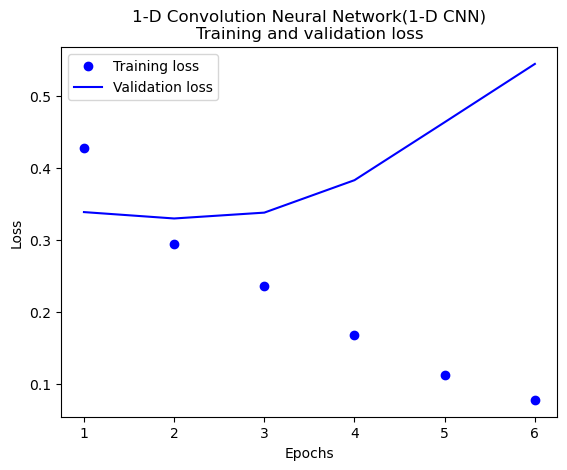

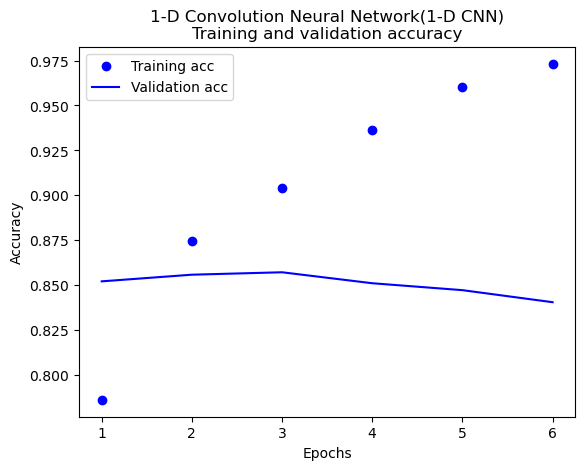

In [25]:
import matplotlib.pyplot as plt

history_dict1 = history1.history
acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1-D Convolution Neural Network(1-D CNN)\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('1-D Convolution Neural Network(1-D CNN)\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

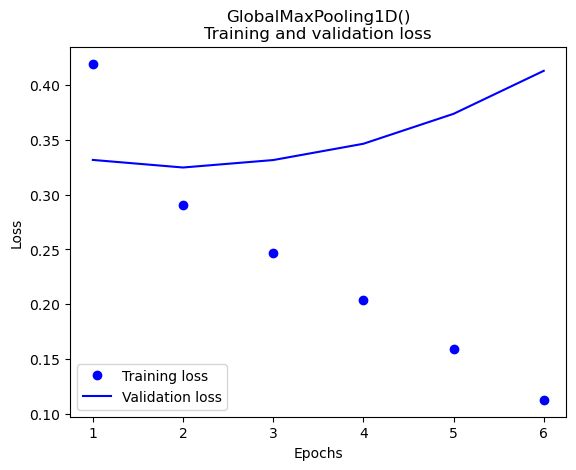

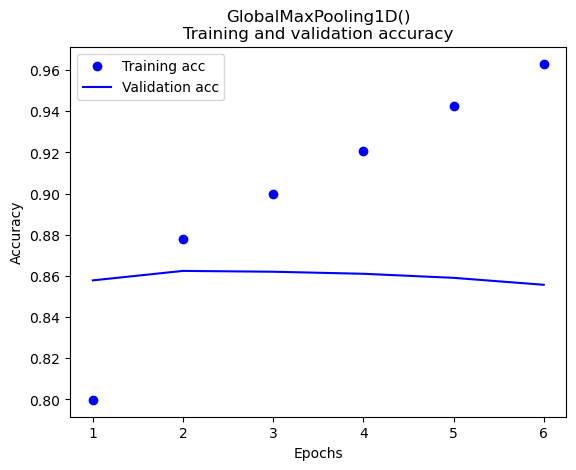

In [26]:
history_dict2 = history2.history
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling1D()\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling1D()\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

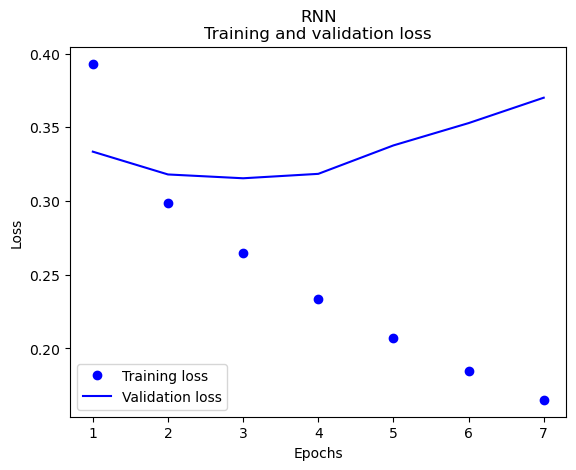

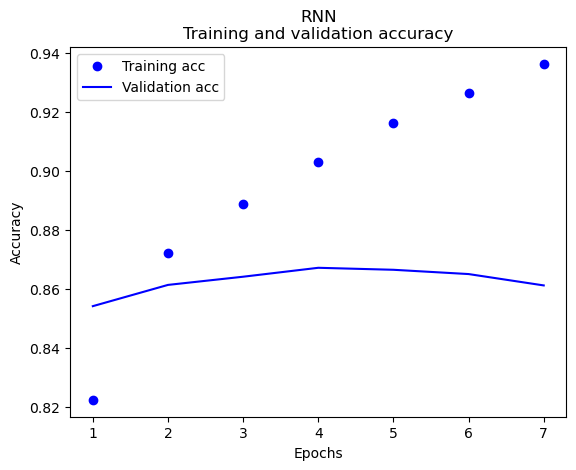

In [27]:
history_dict3 = history3.history
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

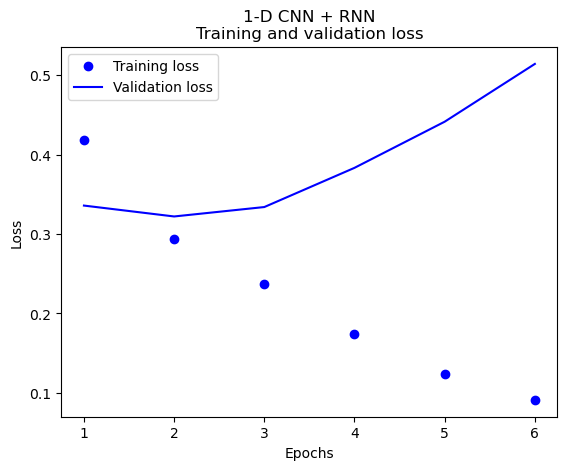

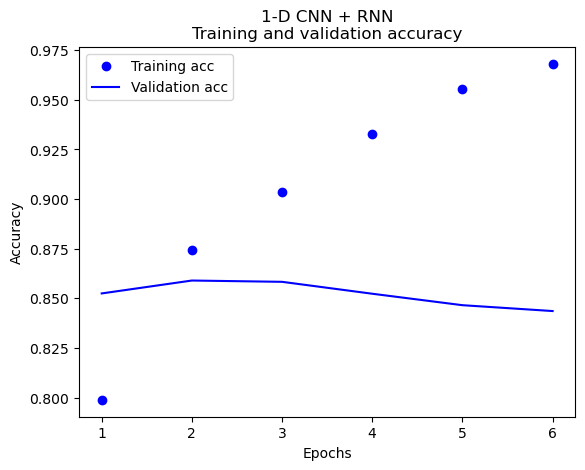

In [28]:
history_dict4 = history4.history
acc = history_dict4['accuracy']
val_acc = history_dict4['val_accuracy']
loss = history_dict4['loss']
val_loss = history_dict4['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1-D CNN + RNN\nTraining and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('1-D CNN + RNN\nTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()